# House Prices : Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

Kaggle : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

<pre>
<b>
* 회귀(Regrassion) 란?
둘 사이의 상관관계를 모델링하는 기법( Y = w₁X₁ + w₂X₂ + ... )
w(weight) = 회귀계수(Coefficient) 또는 가중치(Weight)
Fiture와 결정값 학습을 통해 최적의 회귀계수를 찾는 것.
</b>
*독립변수 개수
  # 1개 : 단일회귀
  # 多  : 다중회귀
*회귀계수 결합
  # 선형회귀 (가장 많이 사용. 규제 방법에 따라 유형 나뉨)
  # 비선형회귀
</pre>

<pre>
<font color='red'>
* 분석절차</font>
1. EDA
  - dataframe 타입별(카테고리형/수치형) 피쳐 분류<br>
2. 결측치 확인/피쳐삭제/채우기
  - 결측값 대체(수치형:평균 / Object형:'None')
  
3. 수치형 피쳐 데이터값 확인
  - target 피쳐 분리
  - unique ID 피쳐 삭제
  
4. 수치형 피쳐 상관분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인
  
5. 수치형 피쳐 인코딩
  - 인코딩(수치형:unique[:13]
  
6. 수치형 정규화
  - 타켓 분포도 확인/정규화
  - 정규화/스케일 (수치형:skew[:25] 로그변환
  
7. Object형 시각화

8. Outlier 처리
  -아웃라이어제거(수치형:IQR) 
  
9. Object형 피쳐 인코딩

10. 학습모델 선정 / 평가

11. 검증 / 튜닝
</pre>          

# Library & API

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import skew

import warnings
warnings.filterwarnings(action='ignore')

# 분석 데이터 로드

In [8]:
df = pd.read_csv('train.csv')
before_df_shape = df.shape
before_df_shape

(1460, 81)

# 1. DataFrame 타입별 Feature 분류
### ( 카테고리형 / 수치형 )

In [9]:
def type_check(df, num = None):
    # Object Columns 분리
    object_feature = df.dtypes[df.dtypes == 'object'].index
    numeric_feature = df.dtypes[df.dtypes != 'object'].index

    # Columns Check
    print(df.dtypes.value_counts()  , '\n')
    print(object_feature            , '\n')
    print(numeric_feature           , '\n')

    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df)

object     43
int64      35
float64     3
dtype: int64 

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object') 

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'Bsm

# 2. 결측치 확인 / Feature 삭제 / 결측치 채우기

In [10]:
def null_feature_check(df, drop_cnt=None):
    # df만 주어질 시 null 개수 및 비율만 확인.
    # drop_cnt가 주어지면 결측치 컬럼 삭제.

    # Null 개수 및 비율 확인
    null_df = pd.DataFrame()
    isnull_feature = df.isnull().sum()[df.isnull().sum() > 0].index
    null_df['null_cnt'] = df[isnull_feature].isnull().sum()
    null_df['null_rate'] = df[isnull_feature].isnull().sum() / df.shape[0] * 100
    print(null_df, '\n')

    # 결측치 삭제
    if drop_cnt != None:
        drop_isnull_feature = df.isnull().sum()[df.isnull().sum() > drop_cnt].index
        print('삭제될 컬럼 : ', drop_isnull_feature)

        df.drop(drop_isnull_feature, axis=1, inplace=True)
        print('Before : ', before_df_shape)
        print('After : ', df.shape)

    return df


df = null_feature_check(df, 600)

              null_cnt  null_rate
LotFrontage        259  17.739726
Alley             1369  93.767123
MasVnrType           8   0.547945
MasVnrArea           8   0.547945
BsmtQual            37   2.534247
BsmtCond            37   2.534247
BsmtExposure        38   2.602740
BsmtFinType1        37   2.534247
BsmtFinType2        38   2.602740
Electrical           1   0.068493
FireplaceQu        690  47.260274
GarageType          81   5.547945
GarageYrBlt         81   5.547945
GarageFinish        81   5.547945
GarageQual          81   5.547945
GarageCond          81   5.547945
PoolQC            1453  99.520548
Fence             1179  80.753425
MiscFeature       1406  96.301370 

삭제될 컬럼 :  Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
Before :  (1460, 81)
After :  (1460, 76)


In [3]:
# Null값 제거
df.fillna(df.mean(), inplace=True)       # 수치형
df.replace(np.nan, 'None', inplace=True) # object형

# null값 없음 확인
df = null_feature_check(df)

Empty DataFrame
Columns: [null_cnt, null_rate]
Index: [] 



<function matplotlib.pyplot.show(close=None, block=None)>

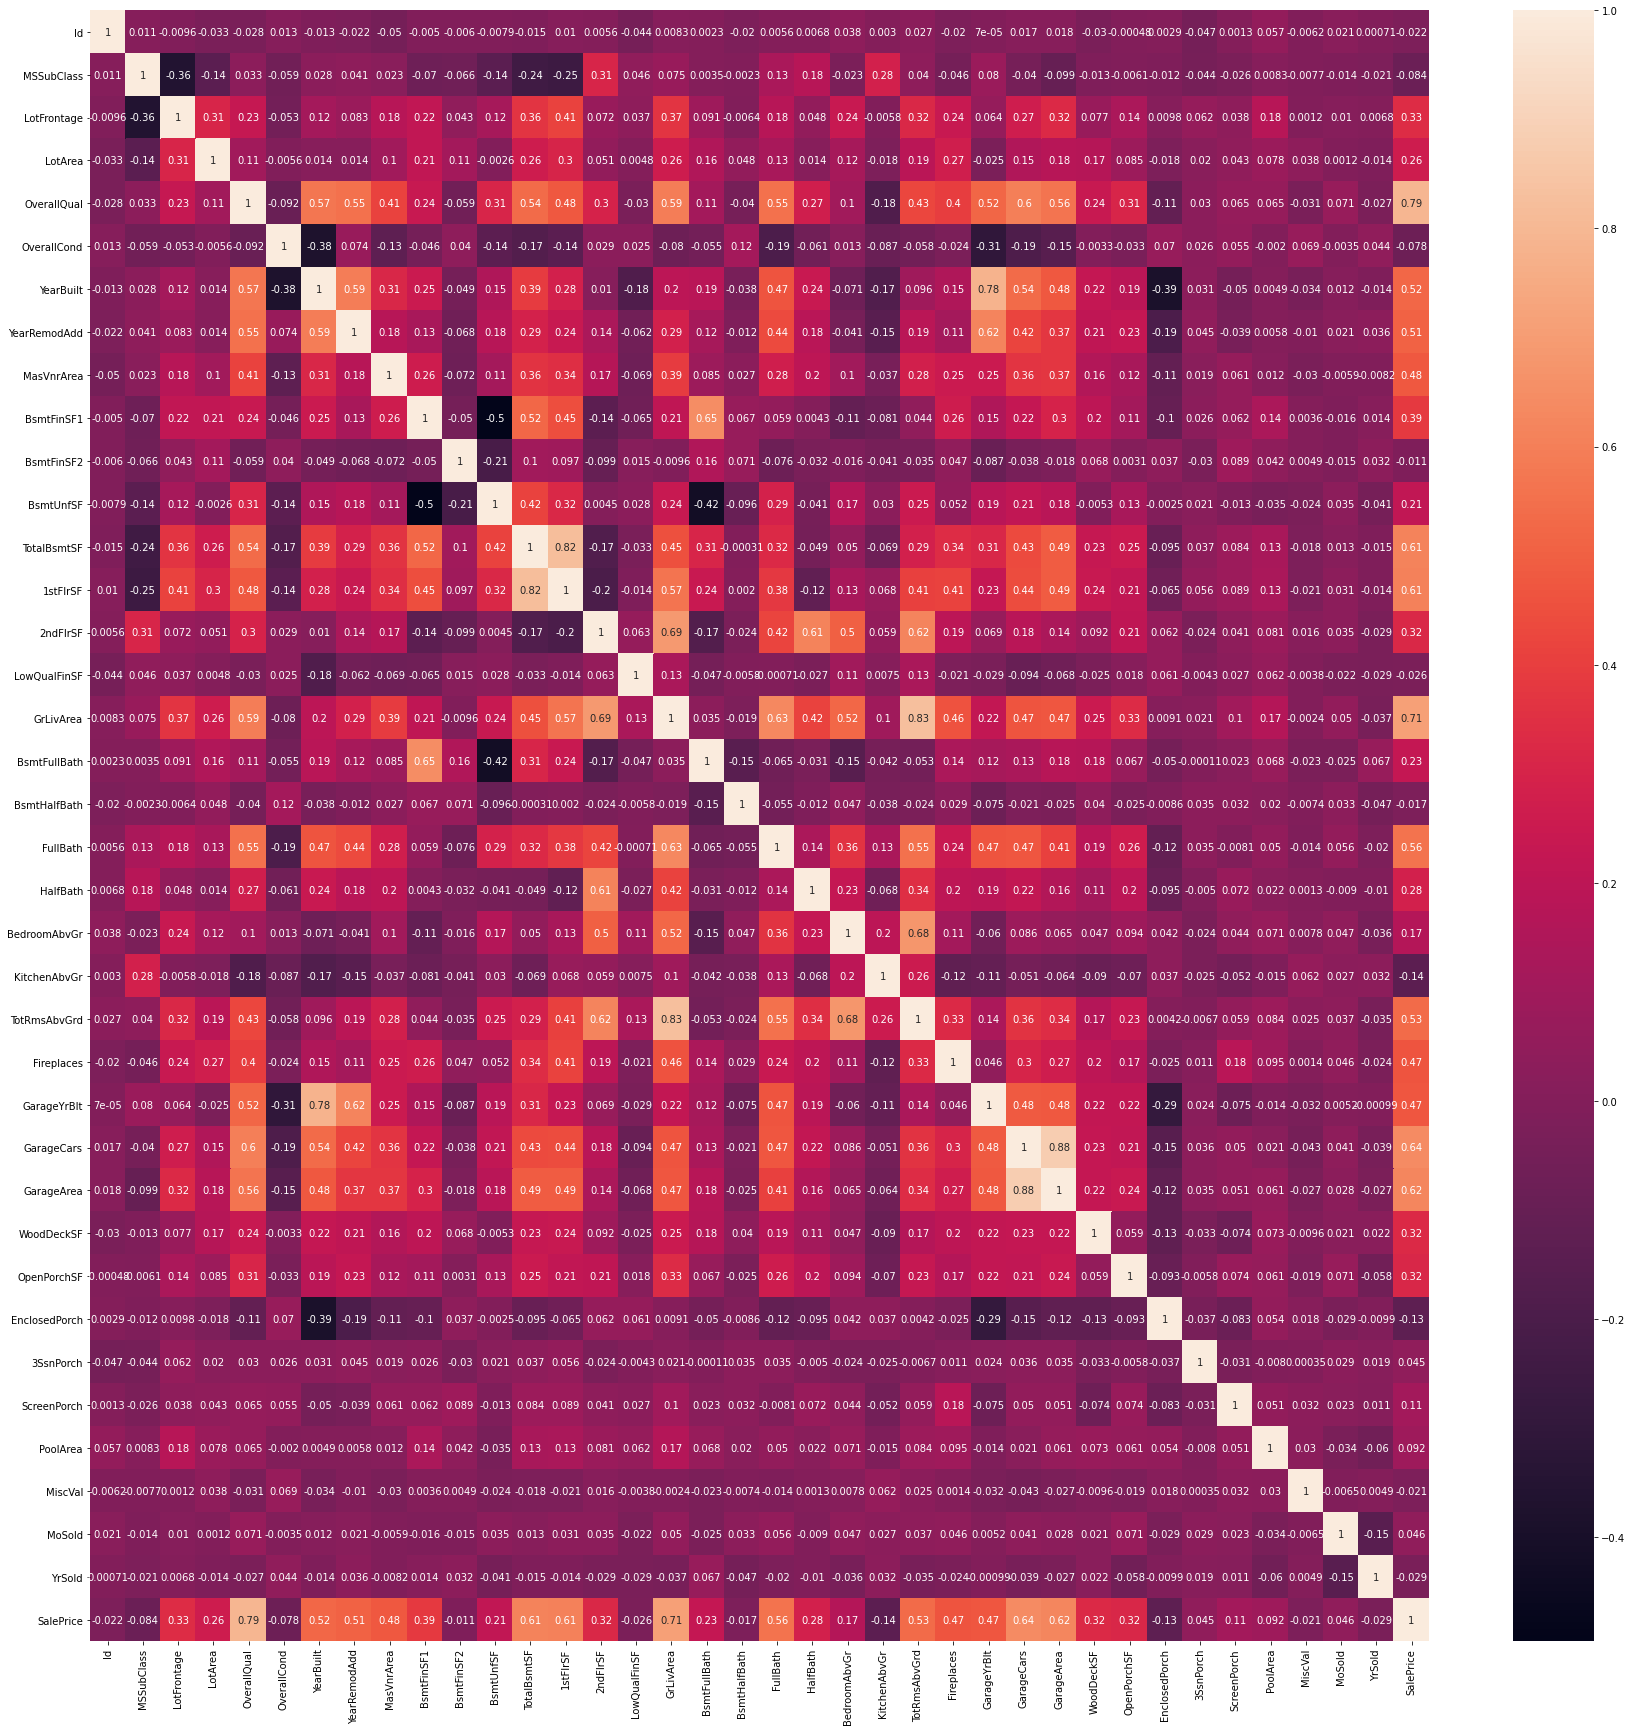

In [4]:
# OneHotEncoding 적용 후 상관관계 분석
# Target feature와 상관관계가 가장 높은 feature를 확인한다. 이를 시각화한다.
# 이를 제외한 기타 수치형 feature들 간의 상관관계를 확인한다. 여기서 다중공선을 없앤다.

plt.figure(figsize=(30, 30))
sns.heatmap(df[numeric_feature].corr(), annot=True)
plt.show

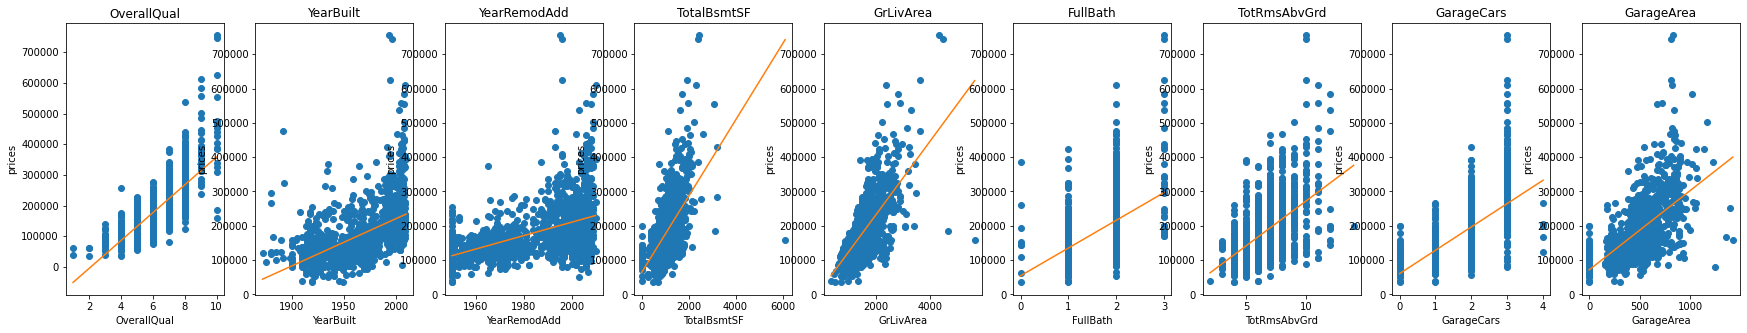

In [5]:
saleprice_corr_feature = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']

plt.figure(figsize=(30, 5))
# i: index
for i, col in enumerate(saleprice_corr_feature):
    # 3 plots here hence 1, 3
    plt.subplot(1, 9, i+1)
    x = df[col]
    y = df['SalePrice']
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

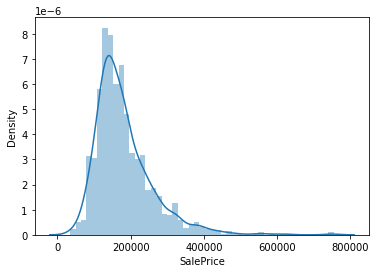

In [6]:
# 왜도(skew)/첨도(kurt) 수치 확인

# MinMaxScaler : 0 ~ 1
# StandardScaler : 평균 0, 분산 1
# np.log() : max값에서 다른값을 뺀 그 차이값을 이용
# np.log1p() : log 취한값이 너무 작으면 언더플로우 발생. 따라서 1을 더해서 사용
sns.distplot(df['SalePrice'])
plt.show()

<AxesSubplot:xlabel='SalePrice_log', ylabel='Density'>

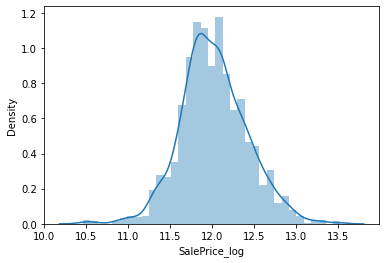

In [7]:
df['SalePrice_log'] = np.log1p(df['SalePrice'])
sns.distplot(df['SalePrice_log'])

                    skew        kurt
MiscVal        24.476794  701.003342
PoolArea       14.828374  223.268499
LotArea        12.207688  203.243271
3SsnPorch      10.304342  123.662379
LowQualFinSF    9.011341   83.234817
KitchenAbvGr    4.488397   21.532404
BsmtFinSF2      4.255261   20.113338
ScreenPorch     4.122214   18.439068
BsmtHalfBath    4.103403   16.396642
EnclosedPorch   3.089872   10.430766
MasVnrArea      2.676412   10.154316
LotFrontage     2.384950   21.848165
OpenPorchSF     2.364342    8.490336
SalePrice       1.882876    6.536282
BsmtFinSF1      1.685503   11.118236
WoodDeckSF      1.541376    2.992951
TotalBsmtSF     1.524255   13.250483
MSSubClass      1.407657    1.580188
1stFlrSF        1.376757    5.745841
GrLivArea       1.366560    4.895121
BsmtUnfSF       0.920268    0.474994
2ndFlrSF        0.813030   -0.553464
OverallCond     0.693067    1.106413
TotRmsAbvGrd    0.676341    0.880762
HalfBath        0.675897   -1.076927
Fireplaces      0.649565   -0.217237
B

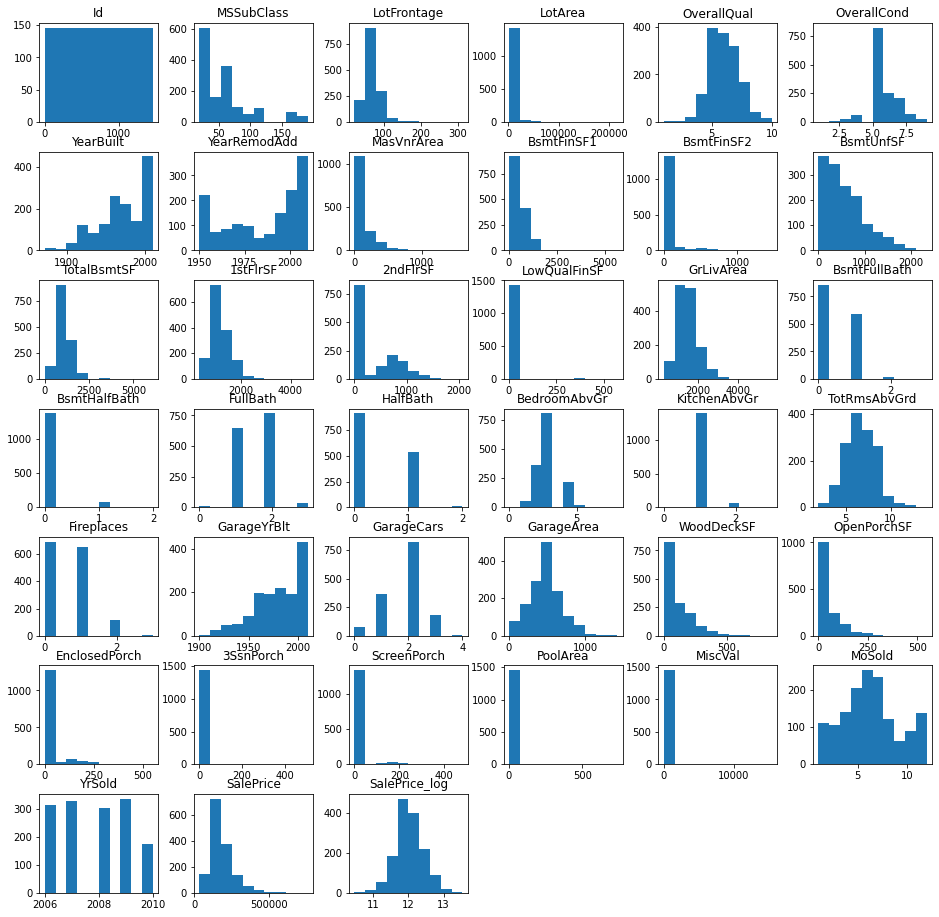

In [8]:
# 정규분포 확인
sk_df = pd.DataFrame()
sk_df['skew'] = df[numeric_feature].skew()  # 왜도 : (=0 : 대칭, <0 : 오른쪽편중, >0 : 왼쪽으로 편중)
sk_df['kurt'] = df[numeric_feature].kurt()  # 첨도 : 뾰족함 (중앙 편중)
df.hist(bins=10, figsize=(16,16), grid=False)
print(sk_df.head(40).sort_values("skew", ascending=False))

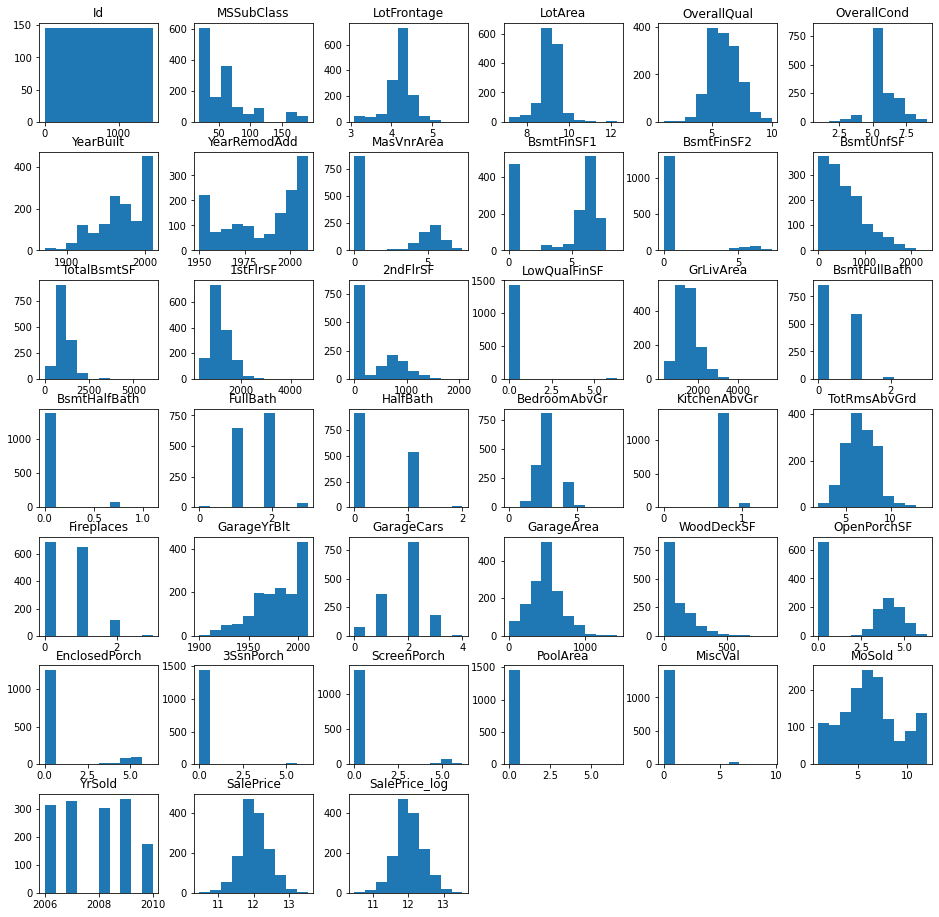

In [9]:
skew_feature = sk_df.head(40).sort_values('skew', ascending=False)[:15].index
# skew_feature = df[skew_feature] - OneHot_numeric_feature
for col in skew_feature:
    df[col] = np.log1p(df[col])
    
# 정규화 후 hist 재확인
df.hist(bins=10, figsize=(16,16), grid=False)
plt.show()

In [10]:
# One-Hot Encoding
# 컬럼의 데이터가 분류로 나뉘어져 있을 때
# 각 데이터가 컬럼명으로 올라가고, 해당 값의 데이터를 1, 나머지를 0 으로 채움.

# 수치형(코드성수치)
OneHot_numeric_feature = []
for col in numeric_feature:
    if df[col].nunique() < 10:
        print(col, df[col].unique())
        OneHot_numeric_feature.append(col)

print("인코딩 적용 전 : ", df.shape)
df_OneHot = pd.get_dummies(data=df, columns=OneHot_numeric_feature)
print("인코딩 적용 후 : ", df_OneHot.shape)

df.head()

OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0.         0.69314718 1.09861229]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [0.69314718 1.09861229 1.38629436 0.        ]
Fireplaces [0 1 2 3]
GarageCars [2 3 1 0 4]
PoolArea [0.         6.24027585 6.47543272 6.35784227 6.32076829 6.17586727
 6.25382881 6.60529792]
YrSold [2008 2007 2006 2009 2010]
인코딩 적용 전 :  (1460, 77)
인코딩 적용 후 :  (1460, 123)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
0,1,60,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699,12.247699
1,2,20,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,...,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016,12.109016
2,3,60,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,...,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171,12.317171
3,4,70,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,...,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405,11.849405
4,5,60,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,...,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220,12.429220


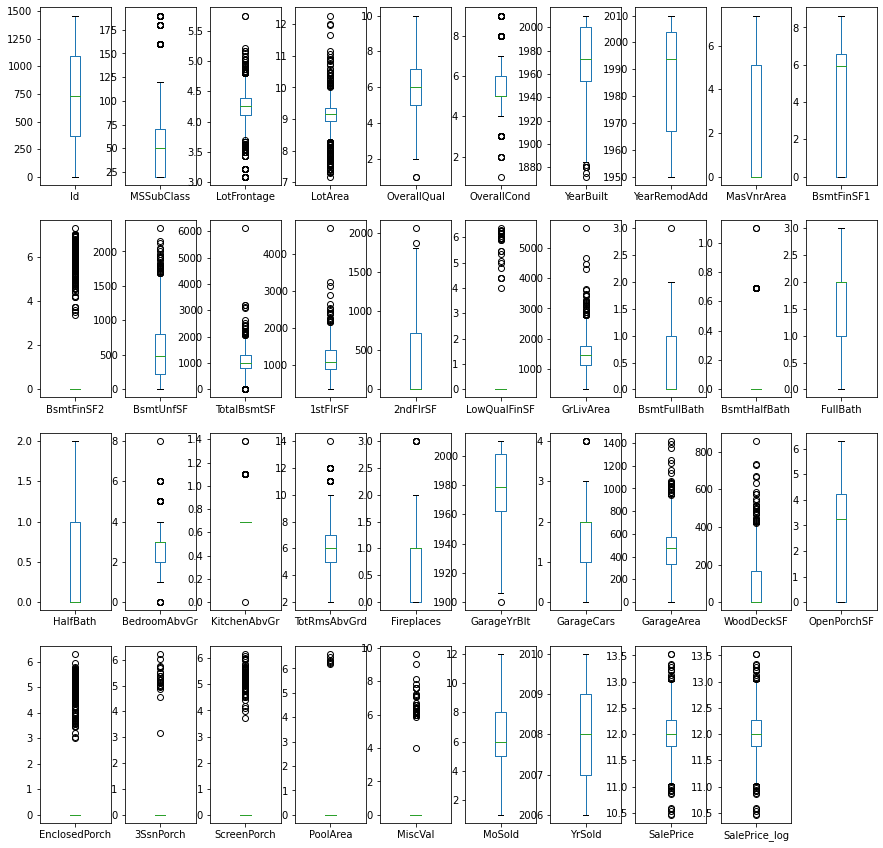

In [11]:
# Boxplot
df.plot(kind='box', subplots=True, figsize=(15,15), layout=(4,10), sharex=False, sharey=False)
plt.show()

In [12]:
# IQR
# 기존에 주어진 범위의 중앙값
# 그 중앙값으로부터 ±25 를 이르는 범위.
# ±25 의 한계점에 1.5를 곱했을 때 나오는 범위 = Limit
# Limit를 벗어나는 값을 Outlier라고 한다.
from collections import Counter

def detect_outliers(df, n, features):
    outlier_idx_list = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_idx_list.extend(outlier_list_col)
    outlier_idx_list = Counter(outlier_idx_list)
    multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)

    return multiple_outliers


Outliers_drop_feature = detect_outliers(df, 2, numeric_feature)
print(Outliers_drop_feature)

[48, 56, 75, 93, 115, 125, 145, 165, 172, 193, 195, 225, 227, 232, 235, 246, 335, 344, 348, 363, 430, 432, 434, 472, 489, 500, 504, 520, 578, 599, 603, 614, 635, 649, 655, 675, 703, 705, 755, 758, 829, 831, 837, 914, 915, 956, 959, 962, 971, 1007, 1029, 1030, 1038, 1039, 1062, 1068, 1088, 1091, 1104, 1160, 1190, 1191, 1219, 1236, 1265, 1266, 1291, 1297, 1304, 1334, 1364, 1367, 1378, 1393, 1416, 1449, 1452, 197, 231, 260, 313, 523, 662, 764, 954, 991, 1061, 1173, 1182, 1298, 53, 185, 249, 425, 529, 588, 661, 769, 828, 848, 1169, 1177, 1184, 1325, 1396, 1405, 375, 533, 88, 218, 304, 390, 676, 745, 749, 919, 1006, 1031, 1041, 1076, 1137, 1156, 1213, 1259, 1268, 1320, 1380, 747, 1349, 7, 113, 116, 129, 166, 330, 358, 440, 499, 502, 510, 888, 944, 953, 1024, 1094, 1205, 1230, 1346, 1386, 137, 224, 278, 496, 798, 803, 843, 1046, 17, 178, 691, 897, 898, 1044, 1373, 198, 1440, 118, 324, 961, 1142, 1328, 1350, 634, 910, 912]


In [13]:
print("Outlier 처리 전 : ", df.shape)
df = df.drop(Outliers_drop_feature, axis=0).reset_index(drop=True)
print("Outlier 처리 후 : ", df.shape)

Outlier 처리 전 :  (1460, 77)
Outlier 처리 후 :  (1285, 77)


In [14]:
# Object Type : 
# LabelEncoding (Pool Extend ... Excellent : 0 1 ... 33)
# OneHotEncoding (1000 0100  0010 0001) :피쳐가 엄청~ 많아진다(시각화X, 분석용)
# pd.get_dummy()

print("인코딩 적용 전 :",df.shape, df_OneHot.shape)
df_OneHot = pd.get_dummies(data=df, columns=object_feature)
print("인코딩 적용 후 :",df_OneHot.shape)

인코딩 적용 전 : (1285, 77) (1460, 123)
인코딩 적용 후 : (1285, 278)


In [15]:
df_OneHot.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,0,1,0,0,0,0,1,0
1,2,20,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,0,1,0,0,0,0,1,0
2,3,60,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,0,1,0,0,0,0,1,0
3,4,70,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,0,1,1,0,0,0,0,0
4,5,60,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,0,1,0,0,0,0,1,0


In [16]:
# 데이터 분할
df_OneHot.drop(['Id'], axis=1, inplace = True)

y = df_OneHot["SalePrice"]
y_log = df_OneHot['SalePrice_log']
X_OneHot = df_OneHot.drop(["SalePrice", 'SalePrice_log'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_OneHot, y_log, random_state=11, test_size=0.3)


In [17]:
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
models = [lr, ridge, lasso]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print(model.__class__.__name__, mse, np.sqrt(mse))

LinearRegression 0.014042635398285947 0.11850162614194772
Ridge 0.012452294239105733 0.11158984827978634
Lasso 0.030080059822904483 0.1734360395733957


In [21]:
for model in models:
    
    neg_mse_5 = -1 * cross_val_score(model, X_OneHot, y_log, scoring='neg_mean_squared_error', verbose=0, cv=5)
    print(model.__class__.__name__, np.mean(neg_mse_5), np.sqrt(np.mean(neg_mse_5)))

LinearRegression 4367238000460.143 2089793.7698395369
Ridge 0.012825641797638936 0.11325035009941001
Lasso 0.026756120206102962 0.16357298128389958


In [27]:
cf_df = pd.DataFrame()
for model in models:
    cf_df['model'] = model.__class__.__name__
    cf_df['coef'] = model.coef_
    cf_df['col'] = X_train.columns
    cf_df.sort_values(by='model', ascending=False)[:15]
    print(cf_df.head(15))

   model      coef           col
0    NaN -0.000026    MSSubClass
1    NaN  0.004794   LotFrontage
2    NaN  0.077346       LotArea
3    NaN  0.038886   OverallQual
4    NaN  0.035925   OverallCond
5    NaN  0.001941     YearBuilt
6    NaN  0.000194  YearRemodAdd
7    NaN  0.000061    MasVnrArea
8    NaN -0.002511    BsmtFinSF1
9    NaN -0.018376    BsmtFinSF2
10   NaN -0.000057     BsmtUnfSF
11   NaN  0.000191   TotalBsmtSF
12   NaN  0.000133      1stFlrSF
13   NaN  0.000186      2ndFlrSF
14   NaN  0.007302  LowQualFinSF
    model      coef           col
0   Ridge -0.000066    MSSubClass
1   Ridge  0.004565   LotFrontage
2   Ridge  0.077371       LotArea
3   Ridge  0.040562   OverallQual
4   Ridge  0.036742   OverallCond
5   Ridge  0.001902     YearBuilt
6   Ridge  0.000261  YearRemodAdd
7   Ridge -0.000495    MasVnrArea
8   Ridge  0.000712    BsmtFinSF1
9   Ridge -0.007009    BsmtFinSF2
10  Ridge -0.000048     BsmtUnfSF
11  Ridge  0.000173   TotalBsmtSF
12  Ridge  0.000112      1stFl